# **MODÈLES D'EXPLICATION DES TEMPÉRATURES INTÉRIEURES**

## **1. Importation des données**

#### Création d'un lien avec un Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import de modules Python

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Importation des données

In [ ]:
path = "/content/drive/MyDrive/Bureau d'étude/Codes/Données/"

df_data = pd.read_csv(path + "données_Python.csv")
df_data['DT'] = pd.to_datetime(df_data['DT'], format='%Y-%m-%d %H:%M:%S') # Reconversion en objets Timestamp
df_data = pd.concat([df_data, pd.get_dummies(df_data.day_moment.map(int), prefix='day_moment', drop_first=True)], axis=1) # Création de dummies pour la variable 'day_moment'
del df_data['day_moment'] # on retire la variable 'day_moment' qui est désormais remplacée par toutes les dummies
df_data

,skidID,DT,Puissance,IndoorTemp,OutdoorTemp,Puissance_surf,Puissance_surf_030,Puissance_surf_060,Puissance_surf_090,Puissance_surf_120,IndoorTemp_030,IndoorTemp_060,IndoorTemp_90to120,deltaIndoorTemp,skidType,area,day_moment_2,day_moment_3,day_moment_4,day_moment_5,day_moment_6,day_moment_7,day_moment_8,day_moment_9,day_moment_10,day_moment_11,day_moment_12
0,SSH0000001,2019-10-20 02:00:00,3.50,19.920000,12.0,10.358105,10.278631,10.389011,10.424039,10.406030,19.895556,19.799722,19.404167,0.491389,Resid_Rad_GoodIns,314568.48,1,0,0,0,0,0,0,0,0,0,0
1,SSH0000001,2019-10-20 02:10:00,2.95,19.915000,12.5,10.384596,10.296292,10.362520,10.419918,10.402036,19.910000,19.850000,19.406778,0.503222,Resid_Rad_GoodIns,314568.48,1,0,0,0,0,0,0,0,0,0,0
2,SSH0000001,2019-10-20 02:20:00,3.75,19.896667,13.0,10.649509,10.287461,10.331614,10.416975,10.410867,19.916111,19.886667,19.424000,0.492111,Resid_Rad_GoodIns,314568.48,1,0,0,0,0,0,0,0,0,0,0
3,SSH0000001,2019-10-20 02:30:00,3.25,19.896667,13.0,10.887931,10.464070,10.371351,10.414031,10.434047,19.910556,19.903056,19.473444,0.437111,Resid_Rad_GoodIns,314568.48,1,0,0,0,0,0,0,0,0,0,0
4,SSH0000001,2019-10-20 02:40:00,3.55,19.913333,13.0,10.570035,10.640679,10.468485,10.455240,10.475108,19.902778,19.906389,19.542222,0.360556,Resid_Rad_GoodIns,314568.48,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380314,SSH0000574,2020-04-08 18:10:00,0.60,19.895000,2.0,13.079986,13.316152,13.403352,13.403352,12.612194,19.895500,19.898300,19.875000,0.020500,Resid_FH_GoodIns,45871.61,0,0,0,0,0,0,0,0,1,0,0
380315,SSH0000574,2020-04-11 21:40:00,0.55,20.680000,0.0,11.553987,11.505543,11.505543,9.295268,8.742699,20.660000,20.660000,20.770000,-0.110000,Resid_FH_GoodIns,45871.61,0,0,0,0,0,0,0,0,0,1,0
380316,SSH0000574,2020-04-11 21:50:00,0.50,20.683333,0.0,11.444987,11.541876,11.517654,10.040100,9.055064,20.665000,20.665000,20.770000,-0.105000,Resid_FH_GoodIns,45871.61,0,0,0,0,0,0,0,0,0,1,0
380317,SSH0000574,2020-04-11 22:00:00,0.55,20.688000,0.0,11.553987,11.481321,11.503121,10.766766,9.539508,20.676111,20.668667,20.770000,-0.093889,Resid_FH_GoodIns,45871.61,0,0,0,0,0,0,0,0,0,0,1


## **2. Régressions linéaires**

### 2.a Essai de modèle linéraire par skid
(test de régression linéaire en Python)

In [ ]:
df_data.columns

Index(['skidID', 'DT', 'Puissance', 'IndoorTemp', 'OutdoorTemp',
       'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060',
       'Puissance_surf_090', 'Puissance_surf_120', 'IndoorTemp_030',
       'IndoorTemp_060', 'IndoorTemp_90to120', 'deltaIndoorTemp', 'skidType',
       'area', 'day_moment_2', 'day_moment_3', 'day_moment_4', 'day_moment_5',
       'day_moment_6', 'day_moment_7', 'day_moment_8', 'day_moment_9',
       'day_moment_10', 'day_moment_11', 'day_moment_12'],
      dtype='object')

22.312033797698774
[ 0.03762008 -0.04072754  0.08448838 -0.14897099  0.20316449 -0.151365
  0.24767624  0.62675742  0.55397283  0.45788259  0.43577579  0.41381795
  0.32239913  0.28957333  0.28591104  0.20800028  0.10985932]
22.3137770449662
[ 0.03766277 -0.04034584  0.08304958 -0.14615781  0.20061325 -0.15053351
  0.24509578  0.62386135  0.55110262  0.45503038  0.43300863  0.41117576
  0.31985727  0.28699614  0.28343412  0.20548733  0.10759914]
R2 : 0.28021
RMSE : 1.4000826038663001


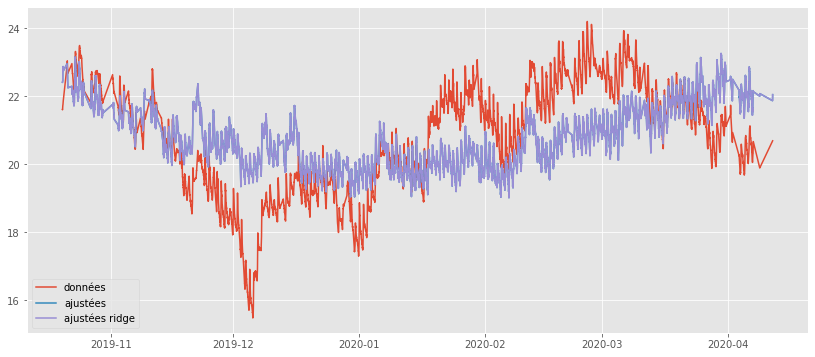

In [ ]:
from sklearn.linear_model import LinearRegression, RidgeCV

# Créer un objet reg lin
mod_lin = LinearRegression()
mod_ridge = RidgeCV(alphas=np.logspace(-6, 6, 13))

# Créer y et X
donnees = df_data[df_data['skidID']=='SSH0000574'].copy()
y = donnees.IndoorTemp
X = donnees[['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120',# 'deltaIndoorTemp', 'IndoorTemp_030', 'IndoorTemp_060', 'IndoorTemp_90to120', 
             'day_moment_2','day_moment_3','day_moment_4','day_moment_5','day_moment_6','day_moment_7','day_moment_8','day_moment_9','day_moment_10','day_moment_11','day_moment_12']]

mod_lin.fit(X,y)
mod_ridge.fit(X,y)

print(mod_lin.intercept_)
print(mod_lin.coef_)
print(mod_ridge.intercept_)
print(mod_ridge.coef_)

# Calcul du R²
print('R2 :',round(mod_lin.score(X,y),5))

RMSE = np.sqrt(((y-mod_lin.predict(X))**2).sum()/len(y))
print('RMSE :',RMSE)

# Analyse des résidus
# plt.plot(y, mod_lin.predict(X),'.')
# plt.show()

# plt.plot(y, y-mod_lin.predict(X),'.')
# plt.show()

plt.figure(figsize=(14, 6))
plt.plot(donnees.DT,y, label='données')
plt.plot(donnees.DT,mod_lin.predict(X), label='ajustées')
plt.plot(donnees.DT,mod_ridge.predict(X), label='ajustées ridge')
plt.legend()
plt.show()

### 2.b. Fonction `predictions` pour prédire à l'aide d'un modèle et estimer l'erreur de prédiction

On veut estimer la qualité de nos modèles à partir de leur capacité à prédire précisement la température intérieure pour les 12 prochaines heures. On se crée alors une fonction permettant de créer des blocs de 12h et de calculer des prédictions à partir d'un modèle (il faut bien noter que pour prédire la température intérieure à une certaine date $t+k+1$, il faut d'abord avoir prédit la température à la date $t+k$ car cette dernière sert de variable explicative pour la prédiction de la température intérieure à la date $t+k+1$).  
Afin de permettre le calcul de la température moyenne des 2 dernières heures, il faudra donc aussi s'assurer que l'on a connaissance des données sur 2h avant le bloc de 12h considéré : au total il faut donc trouver un bloc de 14h consécutives (i.e. avec une donnée toutes les 10min) qui contient donc $(2+12)\text{h} \times 6$ données $= 84$ données. 

In [ ]:
# Dans un bloc de 12 heures il y a 12h * 6 = 72 données. 
# Avec les 2h de données précédentes qu'il faut avoir en plus, on arrive ainsi à 84 données (mais les 2h premières heures peuvent
# tout à fait appartenir à un autre bloc puisqu'on ne prédira pas sur celles-ci dans le bloc de 12h considéré)

dates = pd.date_range(df_data['DT'].min(), df_data['DT'].max(), freq='10min') # range de dates allant de la première date observée à la dernière date observée dans les données

list_indexs_blocs_th = [] # liste théorique des indices des blocs (s'il y avait bien une donnée toutes les 10 minutes)
nb_blocs = int((len(dates)-12)/72) # -12 car par exemple, s'il n'y avait que 80 données au total, il n'y aurait pas assez de données pour faire un bloc de 84 données
for i in range(nb_blocs):
  list_indexs_blocs_th.append(range(i*72, (i+1)*72 + 12)) # le +12 étant en fait pour avoir 12 données en plus au début du bloc

noms_skid = sorted(set(df_data['skidID']))

dic_indexs_blocs = {skid:[] for skid in noms_skid} # Contiendra pour chaque skid les indices "absolus" (du dataframe df_data) des blocs de 84 données consécutives trouvés

# Création des indices des blocs
df_dates = pd.DataFrame({'DT' : dates})
for skid in noms_skid:
  df_local = df_data[df_data.skidID == skid].copy() # Copie du data frame pour les données de ce skid
  df_local['indexs_df_data'] = df_local.index       # Permet de conserver les indices "absolus" du dataframe df_data
  df_local = df_dates.merge(df_local, how='outer', on='DT') # On obtient un dataframe avec une ligne toutes les 10 min et des NaN lorsqu'on n'a pas de données pour une certaines dates
                                                            # De plus, les données sont ainsi rangées dans l'ordre chronologique
  for indexs_bloc in list_indexs_blocs_th:
    if not np.any(df_local.loc[indexs_bloc].IndoorTemp.isna()): # Si pour cet ensemble de 84 données consécutives il n'y a pas de données manquantes
      dic_indexs_blocs[skid].append(df_local['indexs_df_data'][indexs_bloc].map(int))

del df_local

In [ ]:
# Vérification qu'il y a bien assez de blocs pour chaque skid
for skid in noms_skid:
  print(skid,':',len(dic_indexs_blocs[skid]),'blocs')

SSH0000001 : 259 blocs
SSH0000068 : 258 blocs
SSH0000121 : 172 blocs
SSH0000198 : 187 blocs
SSH0000218 : 246 blocs
SSH0000241 : 184 blocs
SSH0000258 : 253 blocs
SSH0000275 : 208 blocs
SSH0000339 : 214 blocs
SSH0000341 : 245 blocs
SSH0000353 : 237 blocs
SSH0000381 : 217 blocs
SSH0000402 : 227 blocs
SSH0000449 : 238 blocs
SSH0000457 : 204 blocs
SSH0000518 : 193 blocs
SSH0000574 : 178 blocs


In [ ]:
from sklearn.linear_model import LinearRegression

def predictions(donnees, var_explicatives, modele = LinearRegression()):
  """ Fonction pour mesurer la qualité de prédiction d'un modèle donné.
      Il faut également renseigner les données sur lesquelles on travaille, ainsi que les variables
      explicatives qui doivent être utilisées.
      La fonction renvoie un dataframe avec les prédictions faites sur des blocs de 12h consécutives
      et pour chacun des skid, ainsi que l'erreur de prédiction MAPE pour chaque skid """

  skids = sorted(set(donnees['skidID']))
  MAPE = pd.Series(index = skids, dtype='float64', name="MAPE") # contiendra les MAPE pour chaque skid
  pred = pd.DataFrame()

  for skid in skids:
    num_bloc = 0 # numéro du bloc traité actuellement
    nb_blocs = len(dic_indexs_blocs[skid]) # nombre de bloc de ce skid
    print(skid, ':', '_'*20, '(pourcentage de blocs traités)\n             ', end='') # Pour faire une barre de chargement lors d'un appel à la fonction

    for indexs_bloc in dic_indexs_blocs[skid]:
      num_bloc += 1
      if (num_bloc <= int(nb_blocs/20)*20) and (num_bloc % int(nb_blocs/20) == 0):
        print('#', end='') # Pourcentage de chargement

      appr = donnees.drop(indexs_bloc) 
      test = donnees.loc[indexs_bloc]

      X_appr = appr[var_explicatives]
      y_appr = appr['IndoorTemp']
      modele.fit(X_appr, y_appr)

      X_test = test[var_explicatives].copy()
      y_test_pred = []

      i = 12 # compteur (emplacement de l'indice 'index' dans la liste 'indexs_bloc')
      for index in indexs_bloc[12:]: # On rappelle que les 12 premières données ne servent qu'à assurer les calculs de températures intérieures passées
        
        # Mise à jour de températures intérieures passées si elles servent de variables explicatives
        try:
          X_test.loc[index,'IndoorTemp_030'] = np.mean(X_test.loc[indexs_bloc[(i-3):i],'IndoorTemp_030'])
        except:
          pass
        try:
          X_test.loc[index,'IndoorTemp_060'] = np.mean(X_test.loc[indexs_bloc[(i-6):i],'IndoorTemp_060'])
        except:
          pass

        # Prédictions
        y_test_pred.append( float(modele.predict([X_test.loc[index]])) )

        i += 1

      df_temp = pd.DataFrame(index = indexs_bloc[12:])
      df_temp['skidID'] = skid
      df_temp['DT'] = test.loc[indexs_bloc[12:],'DT']
      df_temp['IndoorTemp'] = test.loc[indexs_bloc[12:],'IndoorTemp'] # vraies valeurs des températures intérieures
      df_temp['IndoorTemp_pred'] = y_test_pred
      df_temp['residus'] = df_temp['IndoorTemp'] - df_temp['IndoorTemp_pred']

      pred = pd.concat([pred, df_temp])
      

    # Calcul du MAPE pour chaque skid
    MAPE[skid] = np.mean(np.abs(pred[pred.skidID==skid].IndoorTemp - pred[pred.skidID==skid].IndoorTemp_pred)/pred[pred.skidID==skid].IndoorTemp)
    print('')

  del df_temp
  print('')
  return pred, MAPE

SSH0000574 : ____________________ (pourcentage de blocs traités)
             ####################

SSH0000574    0.05982
Name: MAPE, dtype: float64


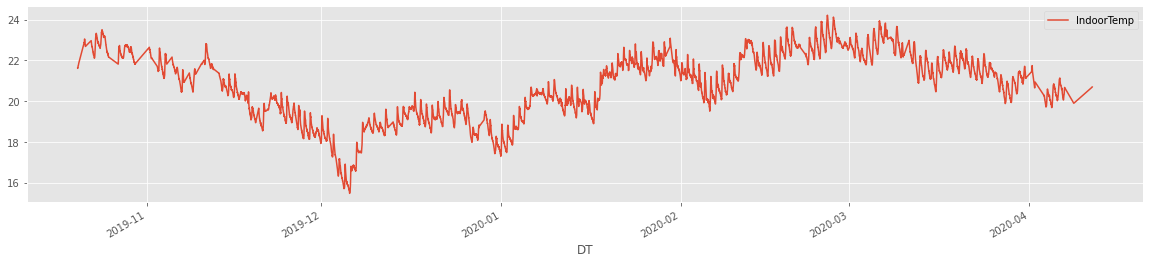

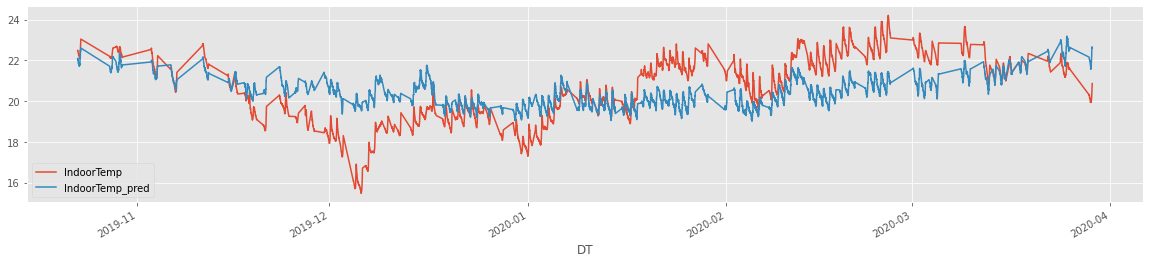

In [ ]:
# Test de la fonction 'predictions'

var_explicatives = ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120',#'deltaIndoorTemp','IndoorTemp_030','IndoorTemp_060','IndoorTemp_90to120',
                    'day_moment_1','day_moment_2','day_moment_3','day_moment_4','day_moment_5','day_moment_6','day_moment_7','day_moment_8','day_moment_9','day_moment_10','day_moment_11','day_moment_12']
donnees = df_data[df_data['skidID']=='SSH0000574']
pred, MAPE = predictions(donnees, var_explicatives, modele = LinearRegression(fit_intercept=False))

print(MAPE)

df_data[df_data.skidID=='SSH0000574'].plot(kind='line',x='DT',y='IndoorTemp', figsize=(20,4))
pred[pred.skidID=='SSH0000574'].plot(kind='line',x='DT',y=['IndoorTemp', 'IndoorTemp_pred'], figsize=(20,4))
plt.show()

### 2.c. Calculs de la qualité de prédiction de différents modèles linéaires
**ATTENTION : CE CODE PREND PRÈS DE 1 HEURE POUR S'EXÉCUTER**  
***(les résultats obtenus ont été enregistrés dans des fichiers joints à ce notebook, et peuvent être lu dans la section 2.e. ci-dessous)***


In [ ]:
beug volontaire pour confirmer que vous voulez bien exécuter le code ci-dessous

In [ ]:
# ATTENTION !!! ce code a tourné pendant 50 minutes !! 

var_expl = {}
var_expl['lm1'] = ['OutdoorTemp', 'Puissance_surf']
var_expl['lm2'] = ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120']
var_expl['lm3'] = ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120',
                   'day_moment_2','day_moment_3','day_moment_4','day_moment_5','day_moment_6',
                   'day_moment_7','day_moment_8','day_moment_9','day_moment_10','day_moment_11','day_moment_12']
var_expl['lm4'] = ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120', 'deltaIndoorTemp']
var_expl['lm5'] = ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120', 'IndoorTemp_030', 'IndoorTemp_060']
var_expl['lm6'] = ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120', 'IndoorTemp_030', 'IndoorTemp_060',
                   'day_moment_2','day_moment_3','day_moment_4','day_moment_5','day_moment_6',
                   'day_moment_7','day_moment_8','day_moment_9','day_moment_10','day_moment_11','day_moment_12']


types_skids = set(df_data.skidType)

pred = {t:{} for t in types_skids}
MAPE = {t:{} for t in types_skids}

for type_skid in types_skids:
  print('=== ',type_skid)
  donnees = df_data[df_data.skidType == type_skid].copy()

  for model in var_expl.keys():
    print('  > ', model)
    pred[type_skid][model], MAPE[type_skid][model] = predictions(donnees, var_expl[model])
  print('')

===  Resid_Rad_GoodIns
  >  lm1
SSH0000001 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000198 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000218 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000258 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000275 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000339 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000402 : ____________________ (pourcentage de blocs traités)
             ####################

  >  lm2
SSH0000001 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000198 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000218 : ____________________ (pourcentage de blocs traités)
  

In [ ]:
# Enregistrement des résultats obtenus ci-dessus :

path = "/content/drive/MyDrive/Bureau d'étude/Codes/En Python/"

# Ensembles de variables des modèles
pd.Series(var_expl, name='variables_explicatives').to_csv(path + 'models' + '.csv')

# Prédictions et MAPE pour chaque modèle et chaque skid par type de skid
for type_skid in types_skids:
  for model in var_expl.keys():
    pred[type_skid][model].to_csv(path + model + '_pred_' + type_skid + '.csv', index=False)
    MAPE[type_skid][model].to_csv(path + model + '_MAPE_' + type_skid + '.csv')

### 2.d. Calculs de la qualité de prédiction de différents modèles linéaires SANS INTERCEPT
**ATTENTION : CE CODE PREND ÉGALEMENT PRÈS DE 1 HEURE POUR S'EXÉCUTER**  
***(les résultats obtenus ont été enregistrés dans des fichiers joints à ce notebook, et peuvent être lu dans la section 2.e. ci-dessous)***


In [ ]:
beug volontaire pour confirmer que vous voulez bien exécuter le code ci-dessous

In [ ]:
# ATTENTION !!! ce code a tourné pendant 50 minutes !! 

var_expl_sans_intercept = {}
var_expl_sans_intercept['lm1_sans_intercept'] = ['OutdoorTemp', 'Puissance_surf']
var_expl_sans_intercept['lm2_sans_intercept'] = ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120']
var_expl_sans_intercept['lm3_sans_intercept'] = ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120',
                                                 'day_moment_2','day_moment_3','day_moment_4','day_moment_5','day_moment_6',
                                                 'day_moment_7','day_moment_8','day_moment_9','day_moment_10','day_moment_11','day_moment_12']
var_expl_sans_intercept['lm4_sans_intercept'] = ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120', 'deltaIndoorTemp']
var_expl_sans_intercept['lm5_sans_intercept'] = ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120', 'IndoorTemp_030', 'IndoorTemp_060']
var_expl_sans_intercept['lm6_sans_intercept'] = ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120', 'IndoorTemp_030', 'IndoorTemp_060',
                                                 'day_moment_2','day_moment_3','day_moment_4','day_moment_5','day_moment_6',
                                                 'day_moment_7','day_moment_8','day_moment_9','day_moment_10','day_moment_11','day_moment_12']


types_skids = set(df_data.skidType)

pred_sans_intercept = {t:{} for t in types_skids}
MAPE_sans_intercept = {t:{} for t in types_skids}

for type_skid in types_skids:
  print('=== ',type_skid)
  donnees = df_data[df_data.skidType == type_skid].copy()

  for model in var_expl_sans_intercept.keys():
    print('  > ', model)
    pred_sans_intercept[type_skid][model], MAPE_sans_intercept[type_skid][model] = predictions(donnees, var_expl_sans_intercept[model], LinearRegression(fit_intercept=False))
  print('')

===  Resid_Rad_GoodIns
  >  lm1_sans_intercept
SSH0000001 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000198 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000218 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000258 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000275 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000339 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000402 : ____________________ (pourcentage de blocs traités)
             ####################

  >  lm2_sans_intercept
SSH0000001 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000198 : ____________________ (pourcentage de blocs traités)
             ####################
SSH0000218 : ____________________ (po

In [ ]:
# Enregistrement des résultats obtenus ci-dessus :

path = "/content/drive/MyDrive/Bureau d'étude/Codes/En Python/"

# Ensembles de variables des modèles
pd.Series(var_expl_sans_intercept, name='variables_explicatives').to_csv(path + 'models_sans_intercept' + '.csv')

# Prédictions et MAPE pour chaque modèle et chaque skid par type de skid
for type_skid in types_skids:
  for model in var_expl_sans_intercept.keys():
    pred_sans_intercept[type_skid][model].to_csv(path + model + '_pred_' + type_skid + '.csv', index=False)
    MAPE_sans_intercept[type_skid][model].to_csv(path + model + '_MAPE_' + type_skid + '.csv')

### 2.e. Analyse des résultats

In [ ]:
# Lecture des résultats :

path = "/content/drive/MyDrive/Bureau d'étude/Codes/En Python/"

models_avec_intercept = dict(pd.read_csv(path + "models.csv", index_col=0)['variables_explicatives'])
models_sans_intercept = dict(pd.read_csv(path + "models_sans_intercept.csv", index_col=0)['variables_explicatives'])
models = {**models_avec_intercept, **models_sans_intercept}  # concaténation des deux dictionnaires ci-dessus

types_skids = set(df_data.skidType)
pred = {t:{} for t in types_skids}
MAPE = {t:{} for t in types_skids}

for type_skid in types_skids:
  for model in models.keys():
    pred[type_skid][model] = pd.read_csv(path + model + '_pred_' + type_skid + '.csv')
    MAPE[type_skid][model] = dict(pd.read_csv(path + model + '_MAPE_' + type_skid + '.csv', index_col=0)['MAPE'])

Création d'un dataframe regroupant tous les MAPE

In [ ]:
df_MAPE = pd.DataFrame()
for type_skid in types_skids:
  df_local = pd.DataFrame(MAPE[type_skid])
  df_local['skidType'] = type_skid
  df_local.index.name = 'skidID'
  df_local.set_index(['skidType',df_local.index], inplace=True)
  df_MAPE = pd.concat([df_MAPE,df_local])
del df_local

df_MAPE

lm1  ...  lm5_sans_intercept
skidType          skidID                ...                    
Resid_FH_GoodIns  SSH0000068  0.056688  ...            0.010120
                  SSH0000241  0.113562  ...            0.021333
                  SSH0000341  0.161540  ...            0.044118
                  SSH0000353  0.026048  ...            0.003807
                  SSH0000381  0.103152  ...            0.021349
                  SSH0000457  0.052324  ...            0.013066
                  SSH0000574  0.063178  ...            0.014254
Resid_Rad_GoodIns SSH0000001  0.053810  ...            0.031425
                  SSH0000198  0.085249  ...            0.005857
                  SSH0000218  0.109246  ...            0.035289
                  SSH0000258  0.113944  ...            0.017516
                  SSH0000275  0.039522  ...            0.010373
                  SSH0000339  0.051311  ...            0.009227
                  SSH0000402  0.049941  ...            0.010107
Resid_Rad_BadIns  SSH0000121  0.095769  ...            0.019836
                  SSH0000449  0.050077  ...            0.010659
                  SSH0000518  0.079223  ...            0.008392

[17 rows x 10 columns]

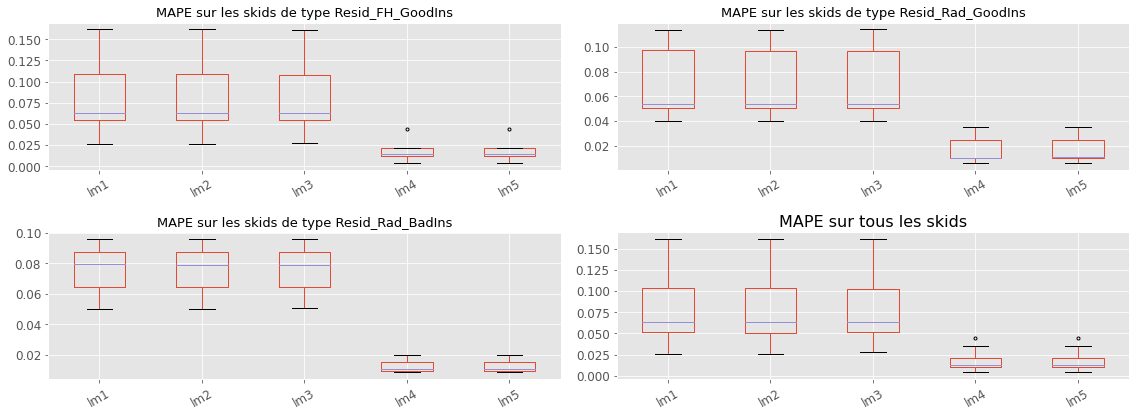

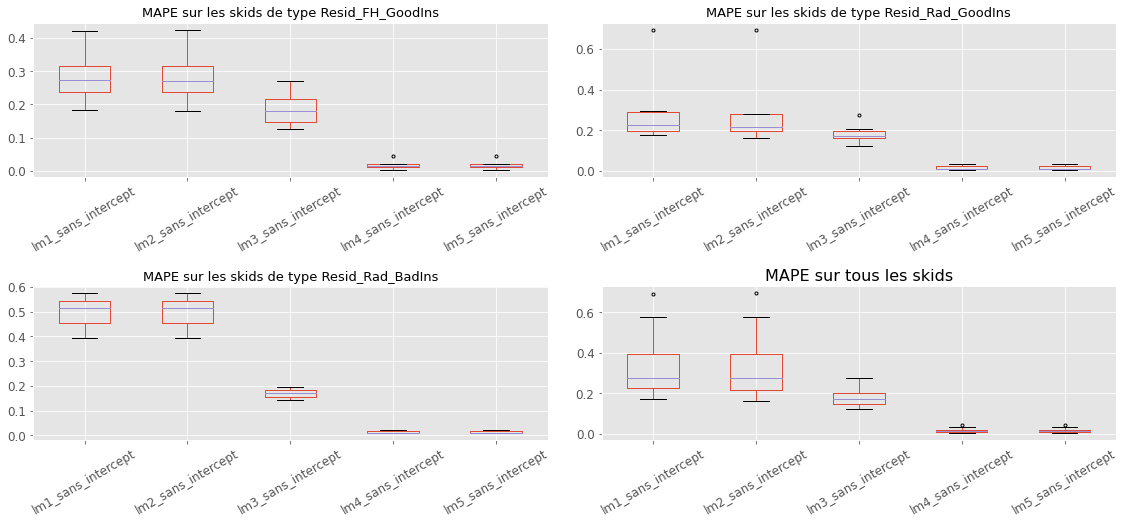

In [ ]:
plt.style.use('ggplot')

i = 1
for type_skid in types_skids:
  plt.subplot(2,2,i)
  df_MAPE[['lm1','lm2','lm3','lm4','lm5']].loc[type_skid].plot(kind='box', figsize=(16,6), fontsize=12, ax=plt.gca(), rot=30, sym='.')
  plt.title('MAPE sur les skids de type ' + type_skid, fontsize=13)
  i += 1

plt.subplot(2,2,4) 
df_MAPE[['lm1','lm2','lm3','lm4','lm5']].plot(kind='box', figsize=(16,6), fontsize=12, ax=plt.gca(), rot=30, sym='.')
plt.title('MAPE sur tous les skids', fontsize=16)
plt.tight_layout(pad=1.5)
plt.show()

i = 1
for type_skid in types_skids:
  plt.subplot(2,2,i)
  df_MAPE[['lm1_sans_intercept','lm2_sans_intercept','lm3_sans_intercept','lm4_sans_intercept','lm5_sans_intercept']].loc[type_skid].plot(kind='box', figsize=(16,7.5), fontsize=12, ax=plt.gca(), rot=30, sym='.')
  plt.title('MAPE sur les skids de type ' + type_skid, fontsize=13)
  i += 1

plt.subplot(2,2,4) 
df_MAPE[['lm1_sans_intercept','lm2_sans_intercept','lm3_sans_intercept','lm4_sans_intercept','lm5_sans_intercept']].plot(kind='box', figsize=(16,7.5), fontsize=12, ax=plt.gca(), rot=30, sym='.')
plt.title('MAPE sur tous les skids', fontsize=16)
plt.tight_layout(pad=1.5)
plt.show()

In [ ]:
for k,v in models.items():
  print("{:>18} : {}".format(k,v))

               lm1 : ['OutdoorTemp', 'Puissance_surf']
               lm2 : ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120']
               lm3 : ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120', 'day_moment_2', 'day_moment_3', 'day_moment_4', 'day_moment_5', 'day_moment_6', 'day_moment_7', 'day_moment_8', 'day_moment_9', 'day_moment_10', 'day_moment_11', 'day_moment_12']
               lm4 : ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120', 'IndoorTemp_030', 'IndoorTemp_060']
               lm5 : ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120', 'IndoorTemp_030', 'IndoorTemp_060', 'day_moment_2', 'day_moment_3', 'day_moment_4', 'day_moment_5', 'day_moment_6', 'day_moment_7', 'day_moment_8', 'day_momen

In [ ]:
# Fonctions pour afficher les résidus ainsi que les températures intérieures réelles et prédites

def show_residus(skid, list_models = models.keys(), subplot_size=(5,2)):
  skid_type = list(df_data.skidType[df_data.skidID == skid])[0]
  print('\nType du skid :', skid_type)
  i = 1
  for model in list_models:
    plt.subplot(subplot_size[0],subplot_size[1],i)
    df = pred[skid_type][model]
    df[df.skidID == skid].plot(x='DT', y='residus', figsize=(16,subplot_size[0]*4), color='#0f0f8f', ax=plt.gca(), rot=20, legend=False)
    plt.title("Skid {:d} : résidus de {} (MAPE = {:.4f})".format(int(skid[3:]), model, MAPE[skid_type][model][skid]))
    i += 1
  plt.tight_layout(pad=1.5)
  plt.show()

def show_IndoorTemp(skid, list_models = models.keys(), subplot_size=(5,2)):
  skid_type = list(df_data.skidType[df_data.skidID == skid])[0]
  print('\nType du skid :', skid_type)
  i = 1
  for model in list_models:
    plt.subplot(subplot_size[0],subplot_size[1],i)
    df = pred[skid_type][model]
    df[df.skidID == skid].plot(x='DT', y=['IndoorTemp','IndoorTemp_pred'], figsize=(18,subplot_size[0]*4), ax=plt.gca(), rot=20)
    plt.title("Skid {:d} : températures intérieures de {} (MAPE = {:.4f})".format(int(skid[3:]), model, MAPE[skid_type][model][skid]))
    i += 1
  plt.tight_layout(pad=1.5)
  plt.show()


Type du skid : Resid_FH_GoodIns


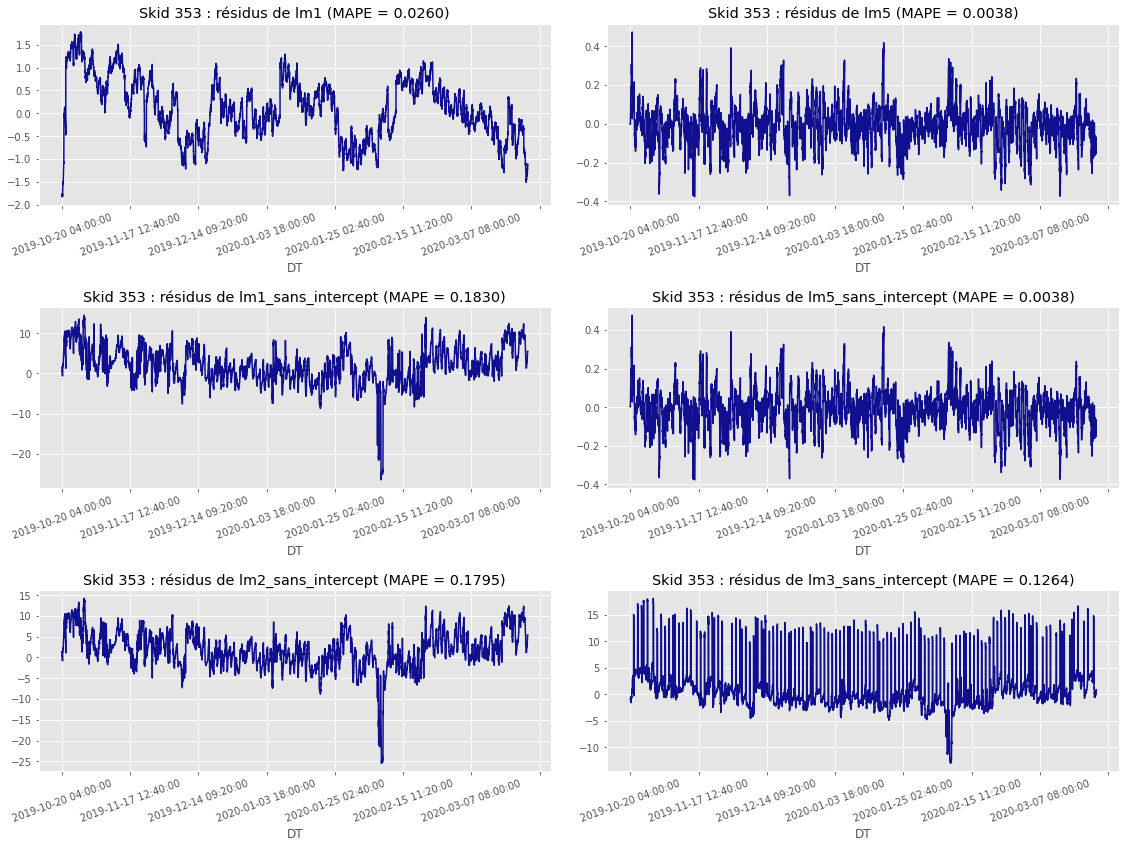


Type du skid : Resid_FH_GoodIns


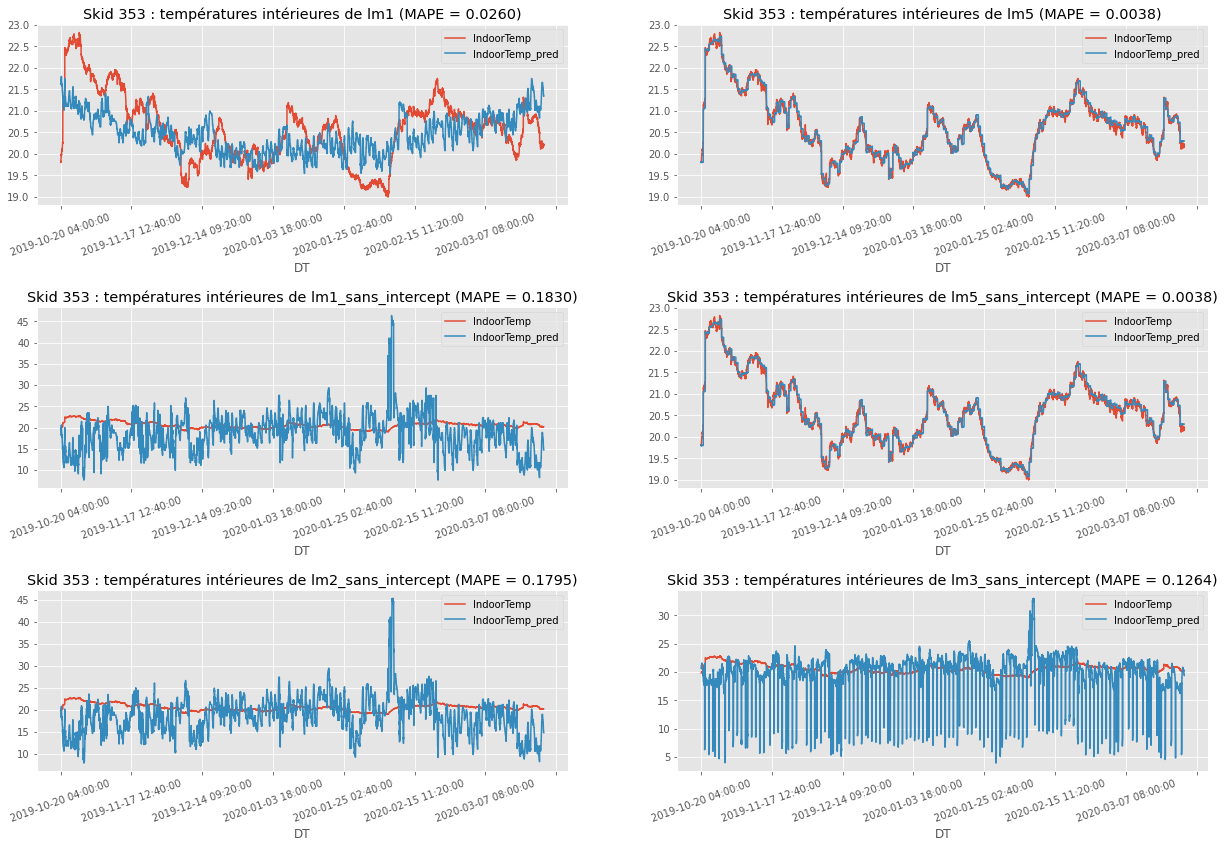

In [ ]:
# Liste des skids : ['SSH0000001', 'SSH0000068', 'SSH0000121', 'SSH0000198', 'SSH0000218', 'SSH0000241', 'SSH0000258', 'SSH0000275', 'SSH0000339',
#                    'SSH0000341', 'SSH0000353', 'SSH0000381', 'SSH0000402', 'SSH0000449', 'SSH0000457', 'SSH0000518', 'SSH0000574']

skid = 'SSH0000353'
list_models = ['lm1','lm5','lm1_sans_intercept','lm5_sans_intercept','lm2_sans_intercept','lm3_sans_intercept']

show_residus(skid, list_models, (3,2))
show_IndoorTemp(skid, list_models, (3,2))

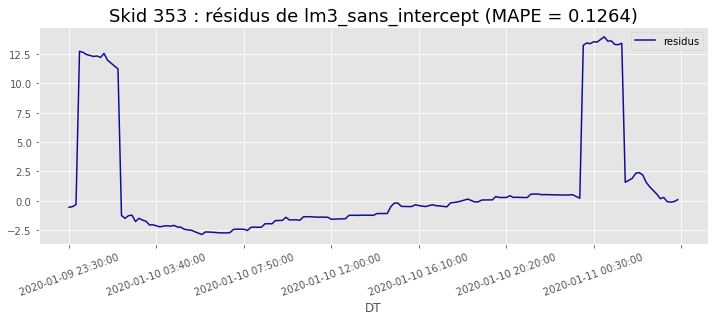

In [ ]:
skid_type = list(df_data.skidType[df_data.skidID == skid])[0]
df = pred[skid_type]['lm3_sans_intercept']
df = df[df.skidID == skid].copy()
df.index = range(df.shape[0])

start_date = '2020-01-09 23:30:00'
start_index = df[df.DT == start_date].index[0]

df.loc[start_index:start_index + 6*29].plot(x='DT', y='residus', figsize=(12,4), color='#0f0f8f', rot=20)
plt.title("Skid {:d} : résidus de lm3_sans_intercept (MAPE = {:.4f})".format(int(skid[3:]), MAPE[skid_type]['lm3_sans_intercept'][skid]), fontsize=18)
plt.show()